# Post-processing VERTEX 70 data to emissivity

This notebook makes use of the [brukeropusreader](https://github.com/qedsoftware/brukeropusreader) package to process the raw OPUS files to emissivity.

This is an example script only, therefore you will need to edit this as appropriate (file paths etc).

* Author: Mary Langsdale (KCL)
* Date: August 2024

## 1.0 Importing & Defining Functions

First let's read in the functions we need. This includes some functions that we've defined here, namely `calc_f_hole`, `calc_sphere_corr` and `raw2emi`.

`calc_f_hole` and `calc_sphere_corr` are both functions related to the substituton error correction.

In [4]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import os
import glob
from brukeropusreader import read_file 

## Self defined functions

def calc_f_hole(R, r):
    """
    r: radius of hole
    R: radius of sphere
    
    Calculate the ratio of surface area of hole to surface area of sphere
    """
    import numpy as np
    h = R - (R**2 - r**2)**(0.5)
    a = 2 * np.pi * R * h
    sas = 4*np.pi * R**2        # surface area of sphere
    f = a/sas
    
    return f

def calc_sphere_corr(Q, Qp):
    '''
    Q:  cap on
    Qp: cap off
    '''
    
    # define constants
    R = 150/2       # radius of sphere
    r_e = 30/2      # radius of entrance port
    # r_d = 5/2       # radius of detector port - nb two of these
    r_s = 30/2      # radius of sample port
    
    # calculate fj for each of holes (ratio of area to area of sphere)
    fe = calc_f_hole(R,r_e)
    fs = calc_f_hole(R, r_s)    # called fm in Goebel 1967
    # fd = 2*calc_f_hole(R, r_d)  #   two of these
    fc = fs                     # ratio for removable cap
    
#    # Constants from the notes 
#    A = 1-fe-fd-fs
#    B = fs
#    G = 1-fe-fd
    
    # the Q factor
    fm=fs
    #rho_w = Q - Qp/((Q-Qp)*(1-fe-fs) + Qp*fc)
    deno = Q*(1-fe-fm) - Qp*(1-fe-fm-fc)        # replacing fc for fd
    rho_w_close = (Q-Qp)/deno      # \rho_w - here is the error in Goebels 1967
    
    return rho_w_close

def raw2emi(v_samp, v_ref, v_op,use_subCorr = True):
    """
    Inputs:
        v_samp:         raw sample data (np array)
        v_ref:          raw gold panel data (np array)
        v_op:           raw open port data (np array)
        use_subCorr:    Apply substitution correction from Goebel 1967 (boolean)

    Output: 
        emissivity array calculated using Kirchhoff's law
    """
    if use_subCorr:
        rho_ref = calc_sphere_corr(v_ref, v_op)
    else:
        rho_ref = 0.98
    
    rho_samp = rho_ref*(v_samp -v_op)/(v_ref - v_op)

    return 1 - rho_samp

## 2. Setting Up Your Filepaths

Now you need to define your base folder in order to read in your data. This example assumes that you have saved all raw OPUS files (.0000, .0001 ...) in a folder called 'raw'.

In [12]:
## Define path 

ifolder = 'C:/Users/Mary Langsdale/Dropbox/Work/KCL/VERTEX/data/2024-07-24/raw/'                # path to folder containing raw files - note that you will need to change this!
print(os.listdir(ifolder))  # view files in folder

['infragold-01.0000', 'infragold-01.0001', 'infragold-01.0002', 'infragold-01.0003', 'infragold-01.0004', 'infragold-01.0005', 'infragold-01.0006', 'infragold-01.0007', 'infragold-01.0008', 'infragold-01.0009', 'openPort-01.0000', 'openPort-01.0001', 'openPort-01.0002', 'openPort-01.0003', 'openPort-01.0004', 'openPort-01.0005', 'openPort-01.0006', 'openPort-01.0007', 'openPort-01.0008', 'openPort-01.0009', 'openPort-01.0010', 'openPort-01.0011', 'openPort-01.0012', 'openPort-01.0013', 'openPort-01.0014', 'openPort-01.0015', 'openPort-01.0016', 'openPort-01.0017', 'openPort-01.0018', 'openPort-01.0019', 'openPort-01.0020', 'openPort-01.0021', 'openPort-01.0022', 'openPort-01.0023', 'openPort-01.0024', 'openPort-01.0025', 'openPort-01.0026', 'openPort-01.0027', 'openPort-01.0028', 'openPort-01.0029', 'openPort-01.0030', 'openPort-01.0031', 'openPort-01.0032', 'openPort-01.0033', 'openPort-01.0034', 'openPort-01.0035', 'openPort-01.0036', 'openPort-01.0037', 'openPort-01.0038', 'openPort

## 3.1 Reading in wavelength data

Before we do any processing on the signal, let's read in the wavelengths. In this example, I used the same .XPM file (experiment file) to collect all files - so the wavelengths are identical for each of the OPUS files. I can therefore read in any file and use the wavelengths for each file. Note that if you had different wavelength ranges (e.g. due to testing spectral resolution) you will need to edit this code to read in wavelengths for particular files. 

Note also that the OPUS file has wavenumbers (wvn) in inverse cm. To convert to wavelength (wvl) in micrometers you simply do:
$$
wvl = 10000/wvn
$$

In [10]:
## Read in wavelengths 
wvs_file = read_file(ifolder + os.listdir(ifolder)[0])
wvn = wvs_file.get_range('ScSm')                   # wavenumber cm-1
wvl = 10000/wvn                                    # wavelength = 10000/ wvn um

## 3.2 Reading in reference data

Now we can read in our reference files. In this example, I've only got one reference measurement (infragold-01.000X where X $\in$ [0, 9]). If you had made multiple over the day, remember to edit the code to select the correct one (I advise using the one made closest in time to the sample measurement).

Here, I'm finding all reference files, opening then using `read_file` function in brukeropusreader, and reading in the single channel data ('ScSm') using the `get_range` function in brukeropusreader. I then calculate a mean and standard deviation.

In [14]:
gold_files = glob.glob(ifolder + '*gold-01*')      # rename this to find your exact gold files for set of measurements
ref_data = {}
for file in gold_files:
    opus_data = read_file(file)
    assert np.all(opus_data.get_range('ScSm') == wvn), 'different wavelength for %s'%file.split('\\')[-1]
    ref_data[file.split('\\')[-1]] = opus_data['ScSm']          # save raw signal in dictionary
ref_df = pd.DataFrame(ref_data)
v_ref = np.array(ref_df.mean(axis = 1))                         # calculate average across all files in that set
v_ref_std = np.array(ref_df.std(axis = 1))                      # useful if considering uncertainty

## 3.3 Plotting reference data

If you want to check the variability of your reference data you can plot them. A good way to do this is to plot the first and last measurements a different color to all other measurements. In this example, I'm plotting the first set of scans blue, the final set red and all other sets black.

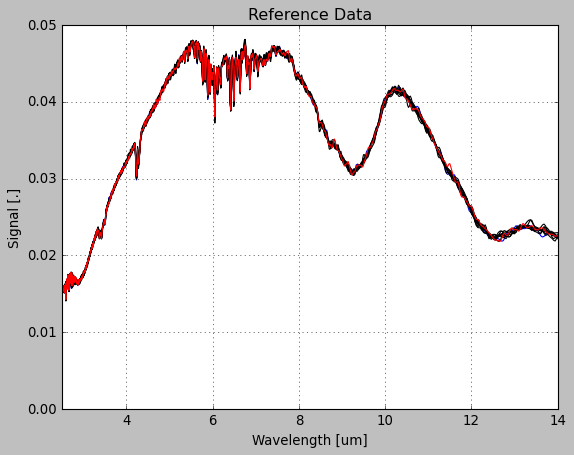

In [30]:
fig, ax = plt.subplots()
ax.grid('on')
ax.set_ylabel('Signal [.]')
ax.set_xlabel('Wavelength [um]')
ax.set_xlim(2.5, 14)           # realistic range
plt.title('Reference Data')
for i in np.arange(0, 10):
    if i == 0:
        c = 'b'                # blue
    elif i == 9:
        c = 'r'                # red
    else: 
        c = 'k'                # black
    plt.plot(wvl, ref_data['infragold-01.000%d'%i], c)

## 3.4 Reading in & plotting open port data

Now do the same for your open port data. Note that this will be a much lower signal than your reference measurement - and much noisier! We even have some measurements under 0 apparently.

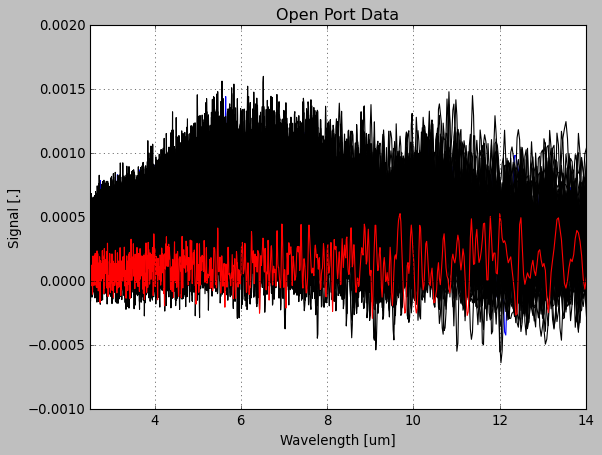

In [31]:
## Read in data
openPort_files = glob.glob(ifolder + '*openPort*')              # rename this to find your exact openPort files for set of measurements
op_data = {}
for file in openPort_files:
    opus_data = read_file(file)
    op_data[file.split('\\')[-1]] = opus_data['ScSm']           # save raw signal in dictionary
op_df = pd.DataFrame(op_data)
v_op = np.array(op_df.mean(axis = 1))                           # calculate average across all files in that set
v_op_std = np.array(op_df.std(axis = 1))                        # useful if considering uncertainty

## Plot data
fig, ax = plt.subplots()
ax.grid('on')
ax.set_ylabel('Signal [.]')
ax.set_xlabel('Wavelength [um]')
ax.set_xlim(2.5, 14)           # realistic range
plt.title('Open Port Data')
for i in np.arange(0, 80):
    if i == 0:
        c = 'b'                # blue
    elif i == 79:
        c = 'r'                # red
    else: 
        c = 'k'                # black
    plt.plot(wvl, op_data['openPort-01.00%02d'%i], c)

## 3.5 Reading in & plotting sample data

Finally do the same for your sample data. Note that in this example I only have one sample - you will likely have multiple.

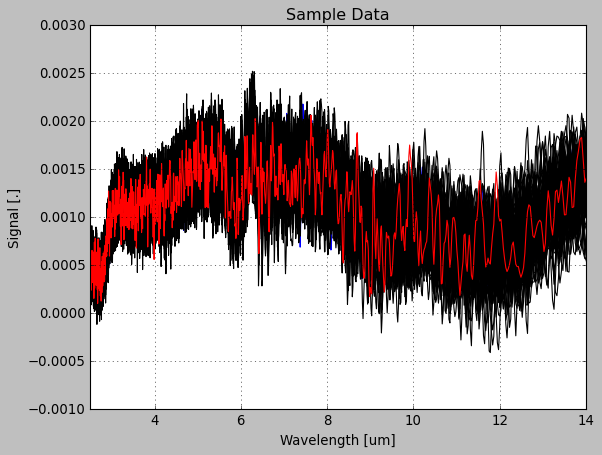

In [32]:
## Read in data

sample_file = glob.glob(ifolder + '*WB1*')              # rename this to find your exact sample files for set of measurements
samp_data = {}
for file in sample_file:
    opus_data = read_file(file)
    samp_data[file.split('\\')[-1]] = opus_data['ScSm']             # save raw signal in dictionary
samp_df = pd.DataFrame(samp_data)
v_samp = np.array(samp_df.mean(axis = 1))                           # calculate average across all files in that set
v_samp_std = np.array(samp_df.std(axis = 1))                        # useful if considering uncertainty


## Plot data
fig, ax = plt.subplots()
ax.grid('on')
ax.set_ylabel('Signal [.]')
ax.set_xlabel('Wavelength [um]')
ax.set_xlim(2.5, 14)           # realistic range
plt.title('Sample Data')
for i in np.arange(0, 80):
    if i == 0:
        c = 'b'                # blue
    elif i == 79:
        c = 'r'                # red
    else: 
        c = 'k'                # black
    plt.plot(wvl, samp_df['WB1-sample01.00%02d'%i], c)

## 3.6 Plotting All Data

Let's now plot sample, reference, and open port averages.  

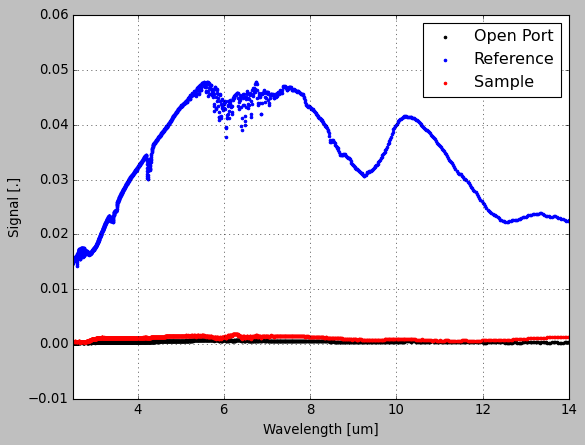

In [43]:
## Plot data
fig, ax = plt.subplots()
ax.grid('on')
ax.set_ylabel('Signal [.]')
ax.set_xlabel('Wavelength [um]')
ax.set_xlim(2.5, 14)           # realistic range
plt.scatter(wvl, v_op, label = 'Open Port', c = 'k', marker = '.', edgecolor = 'k')
plt.scatter(wvl, v_ref, label = 'Reference', c = 'b', marker = '.', edgecolor = 'b')
plt.scatter(wvl, v_samp, label = 'Sample', c = 'r', marker = '.', edgecolor = 'r')
plt.legend(loc = 'best', scatterpoints = 1)

## 3.7 Reading in File Metadata

The OPUS file has a lot of useful metadata that you might want to use as well, including:
* time
* instrument scanner temperature
* instrument humidity

You can see all available information if you type `print(opus_data.keys())`. In this example I'll show you how to extract the above from the most recent file we read in.

In [57]:
# 1.5 useful metadata for individual file

ts = datetime.datetime.strptime(opus_data['ScSm Data Parameter']['TIM'][:8], '%H:%M:%S')        # time [date not correct - it is 1900, 1, 1]
ins_temp = opus_data['Instrument']['TSC']           # temperature deg C
ins_rh = opus_data['Instrument']['HUM']             # rel hum %

print('File %s measured at %s'%(file, opus_data['ScSm Data Parameter']['TIM'][:8]))
print('Temperature and humidity during measurement of %s was %.2f degC and %d%%'%(file, ins_temp, ins_rh))

File C:/Users/Mary Langsdale/Dropbox/Work/KCL/VERTEX/data/2024-07-24/raw\WB1-sample01.0079 measured at 15:59:58
Temperature and humidity during measurement of C:/Users/Mary Langsdale/Dropbox/Work/KCL/VERTEX/data/2024-07-24/raw\WB1-sample01.0079 was 29.10 degC and 1%


## 4 Calculating & Plotting Emissivity
We can now process our data to emissivity! To do this, we simply call the function `raw2emi` that we defined earlier. As these measurements were made using the substitution method, we need to remember to apply the substitution error correction - this is done by setting the Boolean parameter `use_subCorr` within `raw2emi` to be true.

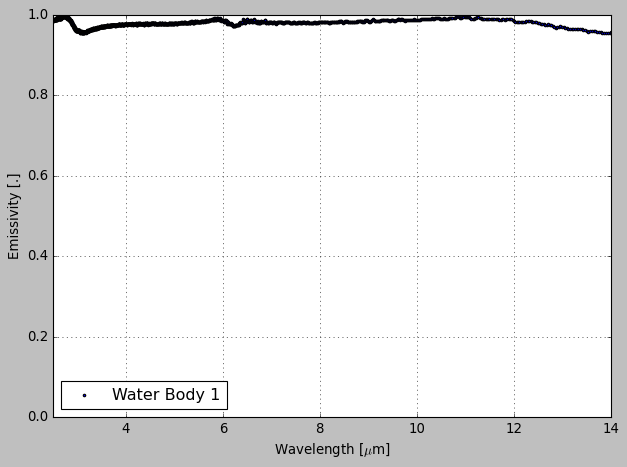

In [59]:
# Process to emissivity
emi = raw2emi(v_samp, v_ref, v_op,use_subCorr = True)

# Plot
fig,ax = plt.subplots(tight_layout = True)
plt.scatter(wvl, emi, marker = '.', label = 'Water Body 1')     # Change for your sample name
plt.legend(loc = 'best', scatterpoints =1)
plt.ylim(0, 1)          # emissivity upper and lower bounds
plt.xlim(2.5, 14)       # sensible wavelength upper and lower bounds for vertex
plt.ylabel('Emissivity [.]')
plt.xlabel('Wavelength [$\mu$m]')
ax.grid('on')